In [2]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.interpolate import interp1d

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_PRTR"): print("\nThe data folder \"_data_PRTR\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_PRTR/"); 
    path_data = path_notebook + "/_data_PRTR/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_PRTR/


In [15]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); 

## Analytical surface

The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


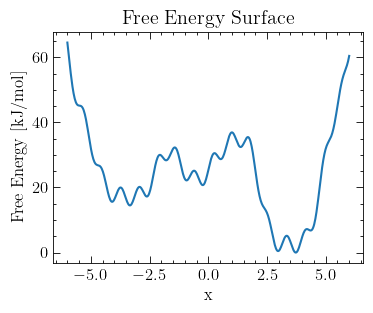

In [3]:
# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 3
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

In [4]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":20,
     				"simulation_folder_path": path_data, "print_info": True}

### Run test PRTR (Parallel Real-Time ReInitialisation) simulation

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); 

S 1  START in exploration phase | MetaD_H=10.0 | MetaD_W=0.24 | BF=50 | Startup: 0.19 sec
    S 1 | t= 0.10ns | nPos:  410/  410: Aofe: 29.84 | AAD: 7.33 | Aofe_all: 29.84  |  AAD_all: 7.33 | ABS_all: nan | 
ALL | t= 0.10ns : 
S 1 END t= 0.45ns | nPos:  1800: Aofe: 7.95 | AAD: 2.59 | Aofe_all: 7.95 | AAD_all: 2.59 | ABS_all: 7.73 | Reason: Exploration stage completed (Memory of all instances: 0.86 MB)
S 2  START in metad phase | MetaD_H=2.0 | MetaD_W=0.13228 | BF=6.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.27 sec
S 3  START in metad phase | MetaD_H=2.0 | MetaD_W=0.13228 | BF=6.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.3 sec
S 4  START in metad phase | MetaD_H=2.0 | MetaD_W=0.13228 | BF=6.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.29 sec
S 5  START in metad phase | MetaD_H=2.0 | MetaD_W=0.13228 | BF=6.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.29 sec
ALL | t= 0.45ns : 
    S 2 | t= 0.40ns | nPos: 1600/ 1600: Aofe: 5.43 | AAD: 1.13 | Aofe_all: 5.43  |  AAD_all: 1.13 | ABS_a

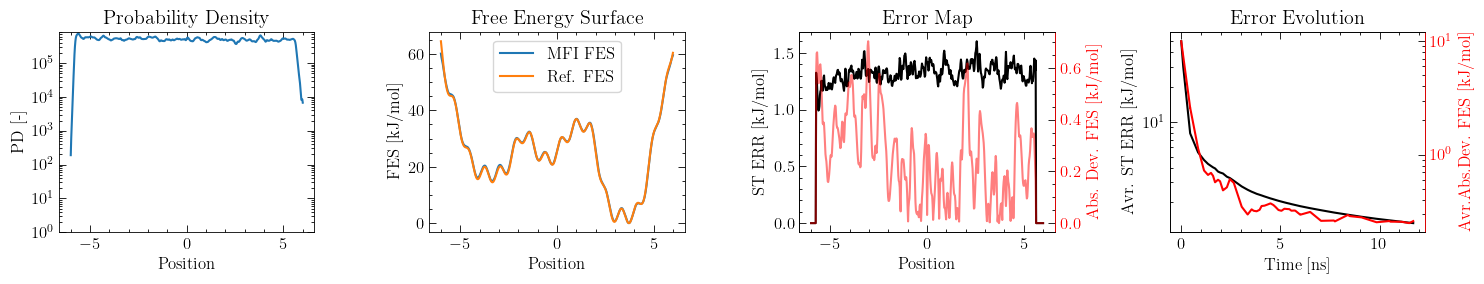


~~~~~~ END ~~~~~~

mfi_PRTR.sim[0].Aofe = 1.3228, mfi_PRTR.sim[0].AAD = 0.2589


In [113]:
# Prepare the MFI object
MFI = MFI_class1D.MFI1D(**default_params)

# Prepare the parallel real-time analysis and re-initialisation object
mfi_PRTR = MFI.MFI_parallel_RTR(parent=MFI, ID="_test", workers=4, workers_exploration=1, goal=0.01, main_error_type="AAD", n_pos_before_analysis=500, 
                                guaranteed_sim_time=0.6, max_sim_time=1, ### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills
                                time_budget=10)  # use this for starting a PRTR-campaign for 0 ns.  
								# restart_PRTR=True, time_budget=15)  # use this for re-starting a PRTR-campaign from existing data.

# Run the parallel real-time analysis and re-initialisation
mfi_PRTR.run()

# Plot+print the final results
mfi_PRTR.sim[0].plot_results()
print(f"\n~~~~~~ END ~~~~~~\n\n{mfi_PRTR.sim[0].Aofe = :.4f}, {mfi_PRTR.sim[0].AAD = :.4f}")


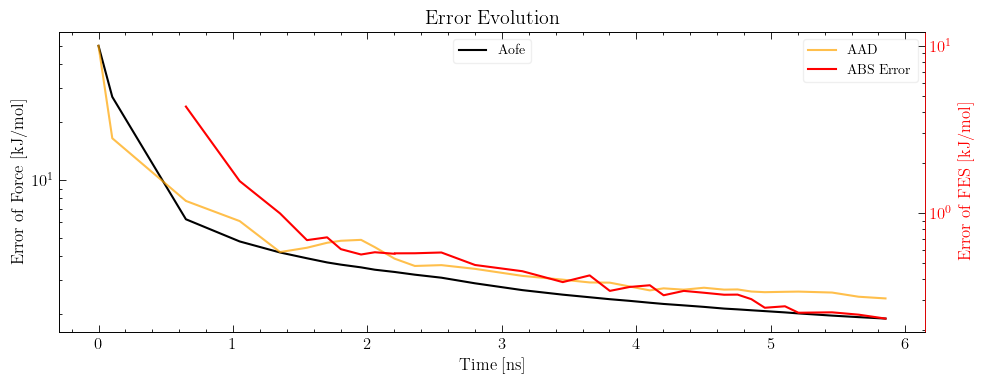

In [107]:
mfi_PRTR.sim[0].plot_errors()

#### Usefull plots

In [111]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); 

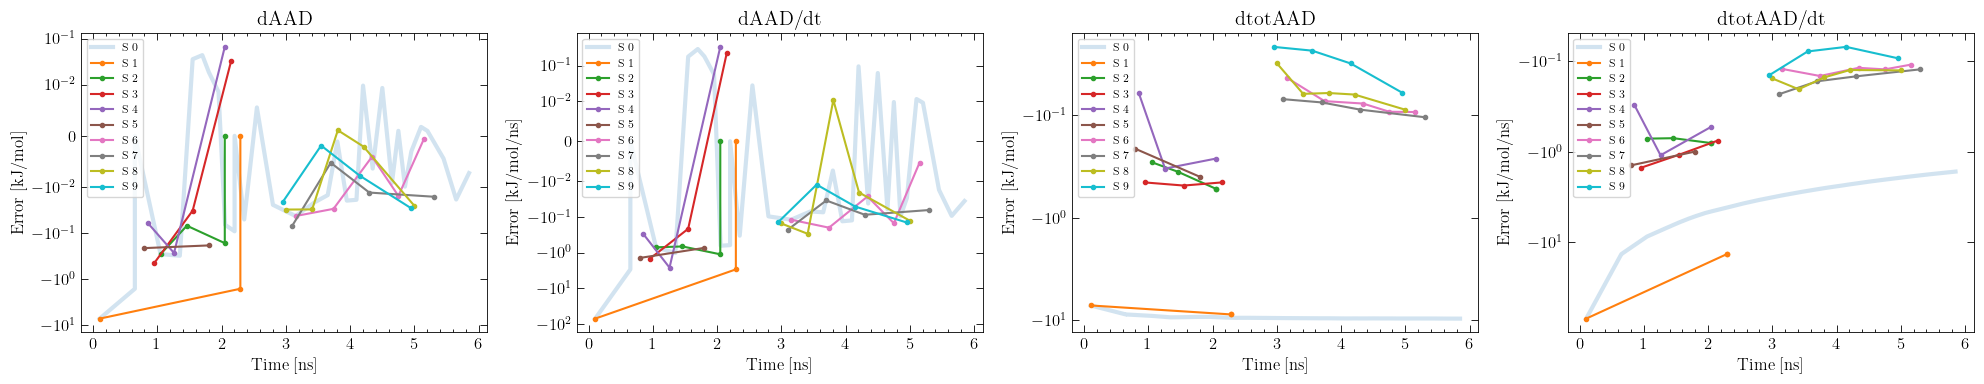

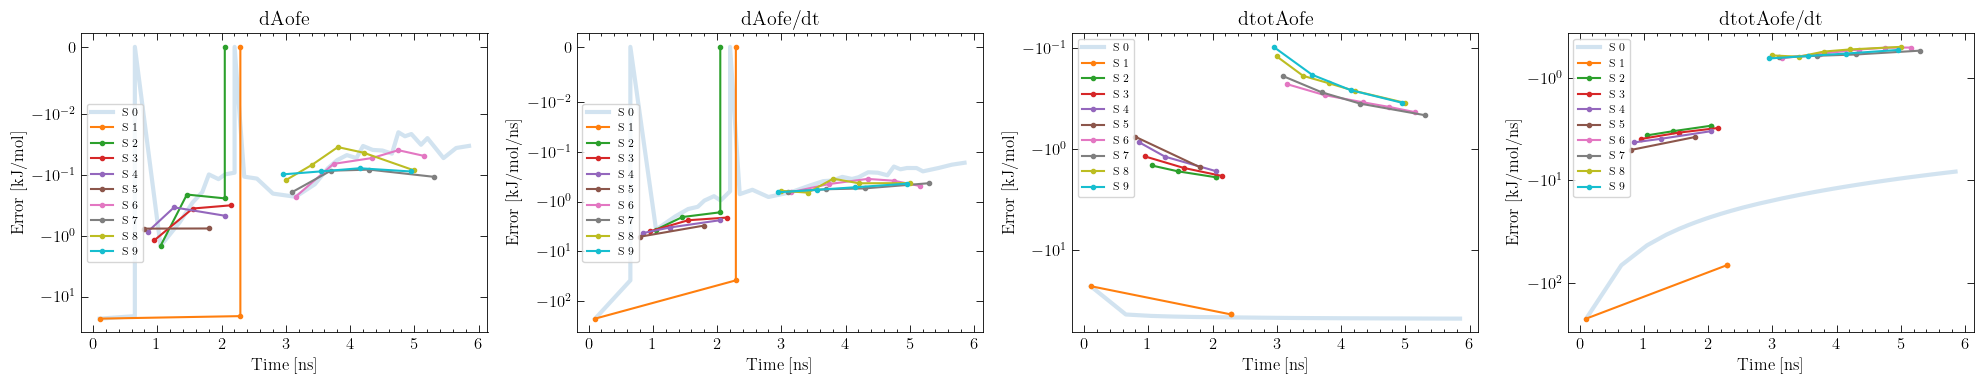

In [112]:
# plot the change in error

# aad
lib1.plot_PRTR_d_error(mfi_PRTR, plot_aad=True)

# Avr on the fly error (error of the mean force)
lib1.plot_PRTR_d_error(mfi_PRTR)

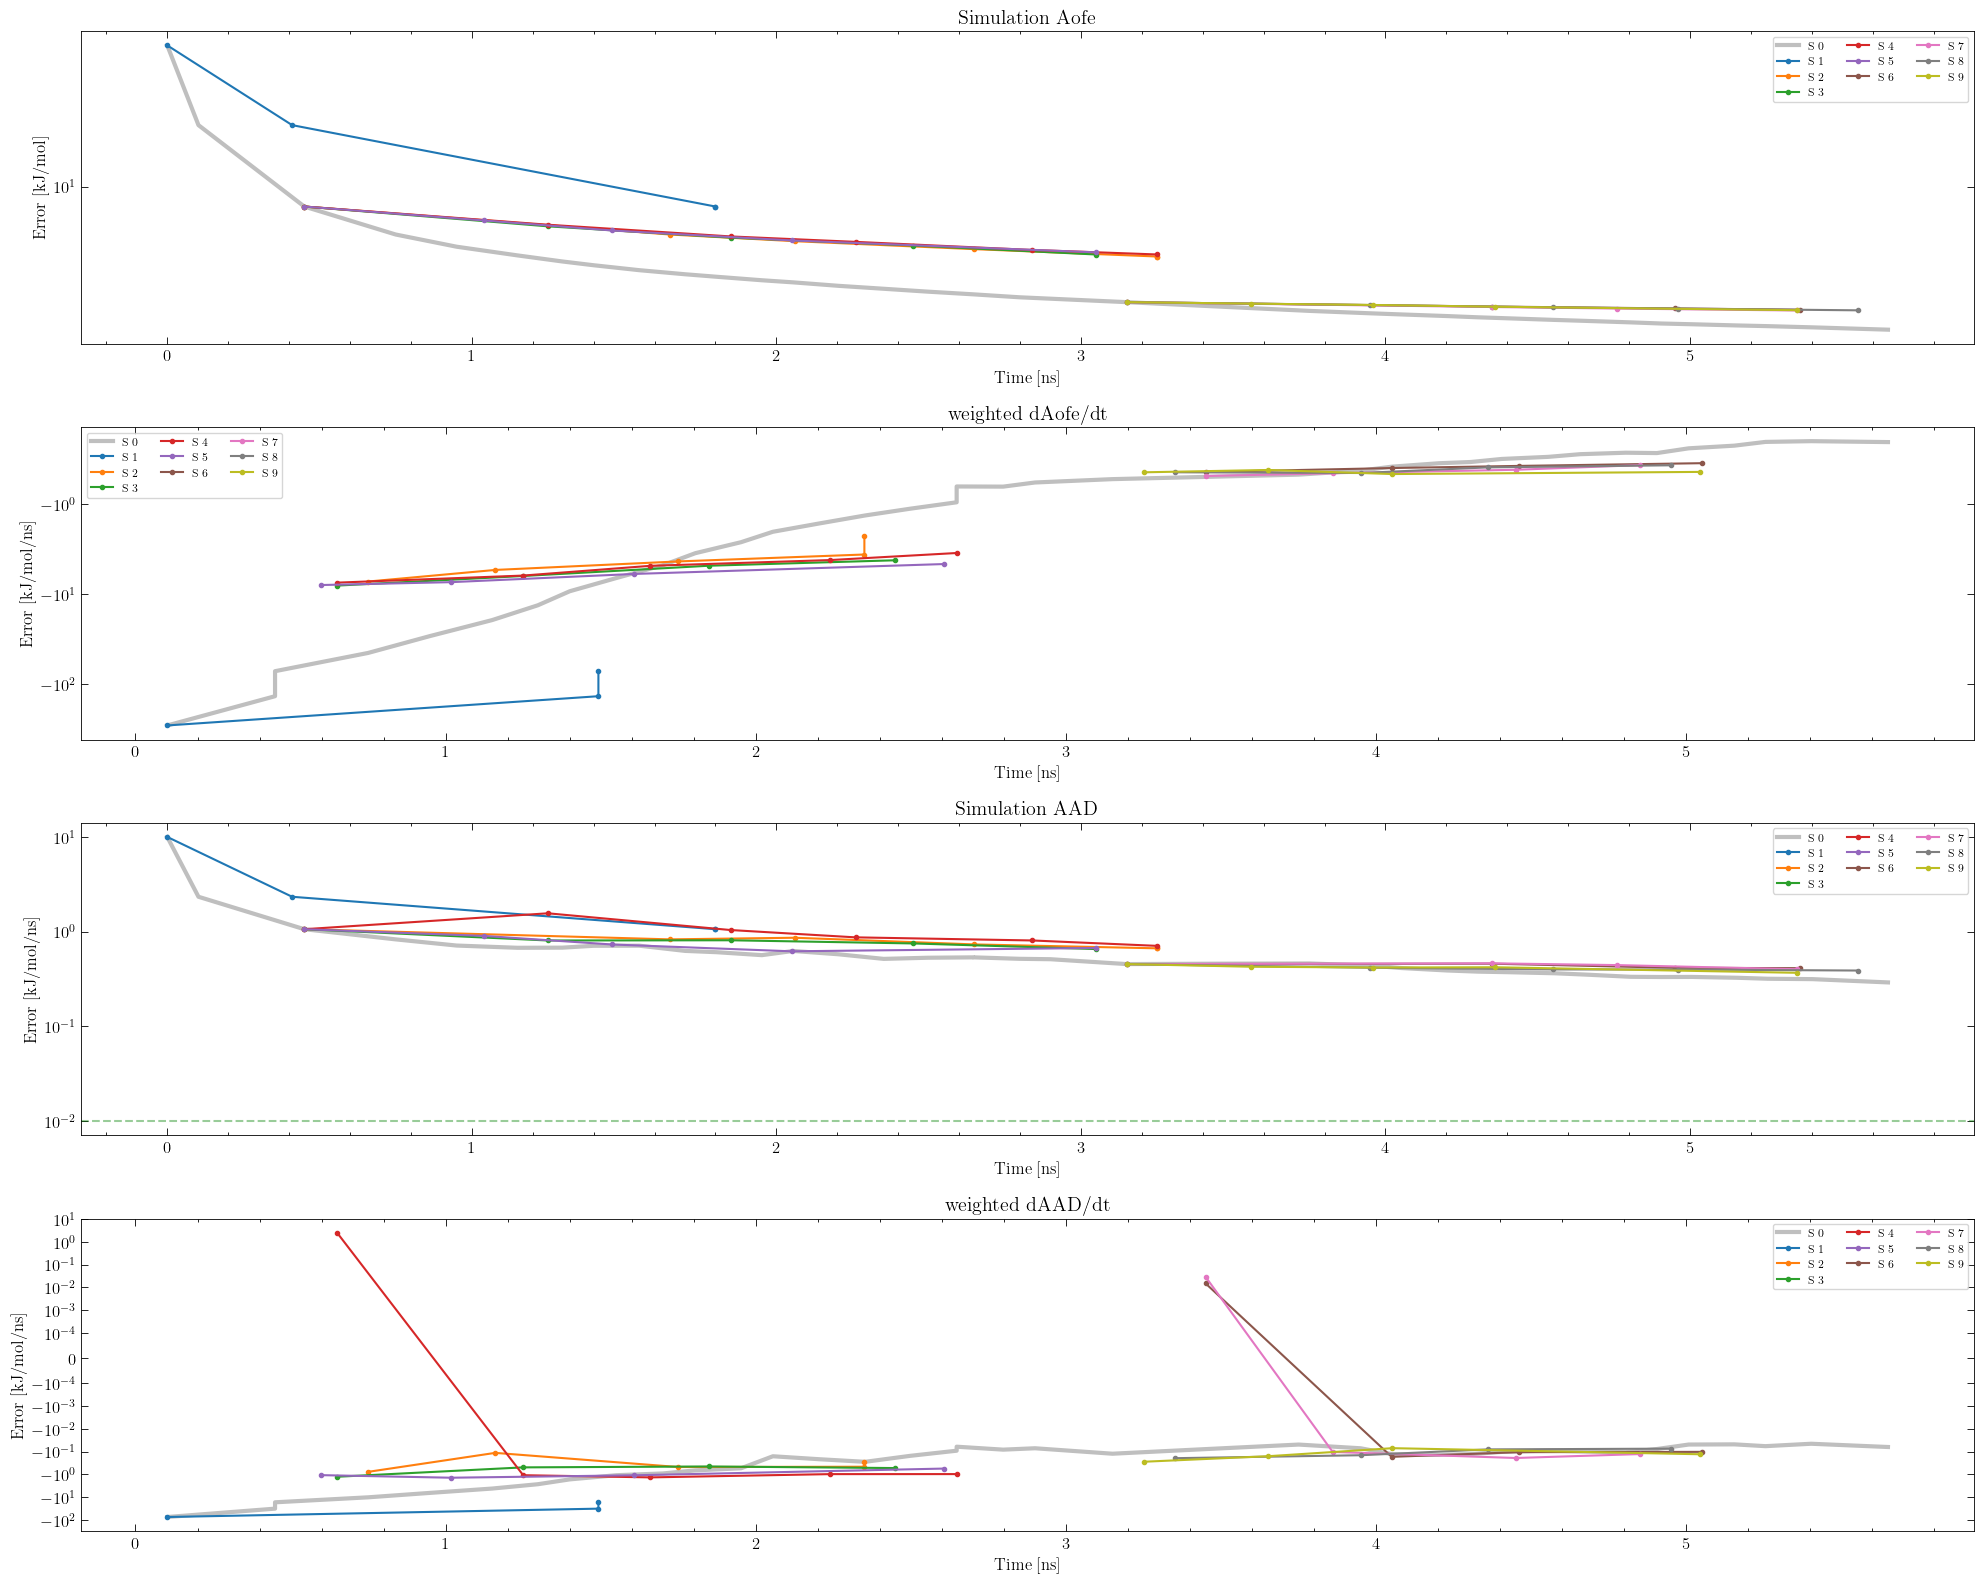

In [105]:
### Mega plot with [d_AAD_w, AAD, d_Aofe_w, Aofe]
lib1.large_error_plot(mfi_PRTR)


In [ ]:
### scatter plot of AAD vs Aofe for all simulations 

### Run Multiple Long Simulations and analysis (for statistical analysis)

In [16]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [5]:
path_data = '/home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_PRTR/'

default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":20,
     				"simulation_folder_path": path_data, "print_info": False}

In [17]:
n_campaigns = 50
min_sim_time, max_sim_time, time_budget = 0.8, 1.2, 5

# loop over campaigns
for i in range(1,n_campaigns+1):
    
    print(f"\n###~~~~~~ Simulation {i} ~~~~~~###\n")

    # Loop over all surfaces
    # for n_surf in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    for n_surf in range(20):
    # for n_surf in [4]:
        
        # Set the surface
        y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
        plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
        
        # Set the path to the campaign folder and the campaign ID
        # print(f"~~~~~~ Simulation {i}: surface {n_surf} ~~~~~~")
        new_path = path_data + f"S{n_surf}/"
        camp_ID = f"_{i}_{time_budget}ns"
        path_camp = new_path + f"PRTRcampaign{camp_ID}/"
        
        #check if directory exists. If does not exist, create it and move to it.
        if not os.path.isdir(path_camp): os.mkdir(path_camp)
        os.chdir(path_camp)
        
        # check if error progression file exists. If it does, skip this iteration, otherwise run the campaign.
        if os.path.isfile(path_camp + f"error_progression_PRTR{camp_ID}"): 
            error = lib1.load_pkl(path_camp + f"error_progression_PRTR{camp_ID}")
            err = lib1.load_pkl(path_camp + f"error_progression{camp_ID}.pkl")
            if error[2][-1] > 2.5: print(f"S{n_surf}: AAD = {error[2][-1]:.4f}, {np.array(error).shape}")
            # print(f"File error_progression_PRTR{camp_ID} already exists. Skipping this iteration."); 
            continue	
        else: print(f"S{n_surf}: Running campaign {i} of {n_campaigns} ")    
      
        ## Prepare MFI object
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "y":y, "plumed_dat_text":plumed_dat_text, "FES_cutoff":FES_cutoff})             
        MFI = MFI_class1D.MFI1D(**new_params)

        mfi_PRTR = MFI.MFI_parallel_RTR(parent=MFI, ID=camp_ID, workers=4, workers_exploration=1, n_pos_before_analysis=400, goal=0.01, main_error_type="AAD", 
                                        guaranteed_sim_time=min_sim_time, max_sim_time=max_sim_time, save_comp_cost=True, 
                                        time_budget=time_budget, reset_forces_after = "Exploration", dynamic_print="off")
        try:
            mfi_PRTR.run()
            print(f"~~~~ End of campaign ~~~~ Aofe={mfi_PRTR.sim[0].Aofe:.4f}, AAD={mfi_PRTR.sim[0].AAD:.4f}, ABS={mfi_PRTR.sim[0].ABS_error:.4f}\n")
            err = mfi_PRTR.sim[0].Avr_Error_list
            lib1.save_pkl( [list(mfi_PRTR.sim[0].Avr_Error_list[:, 0]), list(mfi_PRTR.sim[0].Avr_Error_list[:, 2]), list(mfi_PRTR.sim[0].Avr_Error_list[:, mfi_PRTR.sim[0].aad_index]), list(mfi_PRTR.sim[0].Avr_Error_list[:, mfi_PRTR.sim[0].abs_error_index])], path_camp + f"error_progression_PRTR_{i}_5ns")            
            
        except: print(f"\n~~~~~~~~~~~~ Error in campaign (needs to be repeated) ~~~~~~~~~~~~\n\n\n")



###~~~~~~ Simulation 1 ~~~~~~###


###~~~~~~ Simulation 2 ~~~~~~###


###~~~~~~ Simulation 3 ~~~~~~###


###~~~~~~ Simulation 4 ~~~~~~###

S3: Running campaign 4 of 50 
~~~~ End of campaign ~~~~ Aofe=1.3758, AAD=0.2337, ABS=0.2713


###~~~~~~ Simulation 5 ~~~~~~###


###~~~~~~ Simulation 6 ~~~~~~###


###~~~~~~ Simulation 7 ~~~~~~###


###~~~~~~ Simulation 8 ~~~~~~###


###~~~~~~ Simulation 9 ~~~~~~###

S19: Running campaign 9 of 50 
~~~~ End of campaign ~~~~ Aofe=2.0442, AAD=1.7820, ABS=1.7224


###~~~~~~ Simulation 10 ~~~~~~###

S17: Running campaign 10 of 50 
~~~~ End of campaign ~~~~ Aofe=1.1809, AAD=0.8907, ABS=0.2281


###~~~~~~ Simulation 11 ~~~~~~###


###~~~~~~ Simulation 12 ~~~~~~###


###~~~~~~ Simulation 13 ~~~~~~###

S3: Running campaign 13 of 50 
~~~~ End of campaign ~~~~ Aofe=1.2844, AAD=0.3071, ABS=0.2142


###~~~~~~ Simulation 14 ~~~~~~###


###~~~~~~ Simulation 15 ~~~~~~###


###~~~~~~ Simulation 16 ~~~~~~###


###~~~~~~ Simulation 17 ~~~~~~###


###~~~~~~ Simulation

problem
~~~~ End of campaign ~~~~
mfi_PRTR.sim[0].Aofe = 1.2619, mfi_PRTR.sim[0].AAD = 0.2836




In [8]:
path_data = "/home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_SRTR/"
os.chdir(path_data)

default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, # "dy":dy, "initial_position":[0,0], 
					"System":"Langevin", "pl_grid":pl_x, "position_pace":20, "metad_pace":200, "n_pos_per_window":10, 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":20,
     				"simulation_folder_path": path_data, "print_info": False}

In [9]:
n_campaigns = 100
min_sim_time, max_sim_time, time_budget = 3, 5, 5

# loop over campaigns
for i in range(1,n_campaigns+1):
    
    print(f"\n###~~~~~~ Simulation {i} ~~~~~~###\n")
        
    # Loop over all surfaces
    # for n_surf in [0, 1]:#, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    # for n_surf in range(20):
    for n_surf in range(20):

        # Set the surface
        y, y_string, FES_cutoff = y_list[n_surf], y_string_list[n_surf], FES_cutoff_list[n_surf]
        plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
        print(f"~~~~~~ Simulation {i}: surface {n_surf} ~~~~~~")
        # Set the path to the campaign folder and the campaign ID
        new_path = path_data + f"S{n_surf}/"
        if not os.path.isdir(new_path): os.mkdir(new_path)
        camp_ID = f"_{i}_{time_budget}ns"
        path_campaign = new_path + f"SRTRcampaign{camp_ID}/"
        
        #check if directory exists. If does not exist, create it and move to it.
        if not os.path.isdir(path_campaign): os.mkdir(path_campaign)
        os.chdir(path_campaign)
        
        # check if error progression file exists. If it does, skip this iteration, otherwise run the campaign.
        if os.path.isfile(path_campaign + f"error_progression_SRTR_{i}_5ns"): 
            print(f"File error_progression{camp_ID} already exists. Skipping this iteration.") 
            continue	
        else: print(f"S{n_surf}: Running campaign {i} of {n_campaigns} ")    
      
        ## Prepare MFI object
        new_params = default_params.copy()
        new_params.update({"simulation_folder_path":new_path, "y":y, "plumed_dat_text":plumed_dat_text, "FES_cutoff":FES_cutoff})             
        MFI = MFI_class1D.MFI1D(**new_params)
        
        try:
            ## Run campaign
            MFI.MFI_real_time_ReInit(ID=camp_ID, goal=0.01, main_error_type="AAD", n_pos_before_analysis=500, 
                                    guaranteed_sim_time=min_sim_time, max_sim_time=max_sim_time, time_budget=time_budget)### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills

            ## Print final error and save error progression
            print(f"~~~~ End of campaign ~~~~Aofe={MFI.Aofe:.4f}, AAD={MFI.AAD:.4f}, ABS={MFI.ABS_error:.4f}\n")
            lib1.save_pkl([list(MFI.Avr_Error_list[:, 0]), list(MFI.Avr_Error_list[:, 2]), list(MFI.Avr_Error_list[:, MFI.aad_index]), list(MFI.Avr_Error_list[:, MFI.abs_error_index])], path_campaign + f"error_progression_SRTR_{i}_5ns")
            
        except: 
            print(f"\n~~~~~~~~~~~~ Error in campaign (needs to be repeated) ~~~~~~~~~~~~\n\n\n")




###~~~~~~ Simulation 1 ~~~~~~###

~~~~~~ Simulation 1: surface 0 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 1 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 2 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 3 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 4 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 5 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 6 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 7 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iteration.
~~~~~~ Simulation 1: surface 8 ~~~~~~
File error_progression_1_5ns already exists. Skipping this iter

In [10]:
!pwd

/home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_SRTRS1/SRTRcampaign_1_5ns/simulation_1_5ns_4


## Alanine Dipeptide

In [44]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [42]:
grid = np.linspace(-np.pi, np.pi, 101); 
[pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, periodic=True, print_info=True)

path_AP = path_data + "Alanine_Dipeptide/"
path_input = path_notebook + "/gmx_files/Alanine_Dipeptide/"
plumed_dat_text = f"MOLINFO STRUCTURE={path_input}reference.pdb\nphi: TORSION ATOMS=@phi-2\n"

# _, _, AP_ref = lib2.load_pkl(path_input + "AP_ref_101x101.pkl")
# plt.contourf(X, Y, AP_ref, levels=np.linspace(0, 50, 21), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("$\phi$ [rad]"); plt.ylabel("$\psi$ [rad]"); plt.title("FES of Alanine Dipeptide"); plt.show()

# t_compare, v_compare, aofe_compare, aad_compare = lib2.load_pkl(path_input+"AP_10ns_t_v_aofe_aad_prog.pkl")


In [35]:
# default parameters for the MFI class
default_params = {	"grid":grid, "bw":0.1, #"Z":AP_ref, 
                    "pl_grid":pl_x, "periodic":True, "System":"gromacs", "cv_name":"phi", "plumed_dat_text":plumed_dat_text,
                    "kT":2.49, "time_step":0.001, "position_pace":10, "metad_pace":100, "n_pos_per_window":10,
         			"FES_cutoff":80.0, 
                    # "record_maps":True, "record_forces_e":True, "calculate_FES_st_dev":True, "bootstrap_iter":50, 
                    # "save_error_progression":True, "save_force_terms":True, "save_results":True, "save_mfi_instance":True, 
                    "simulation_folder_path": path_AP+"test/", "ID":"",
				  	
                    "find_sim_init_structure":True, "make_tpr_input_file":True, 
					"trajectory_xtc_file_path_list":[path_input+"traj_0.xtc"], "structure_gro_file_path":path_input+"structure.gro", "mdp_file_path":path_input+"gromppvac.mdp", "top_file_path":path_input+"topology.top", "tpr_file_path":path_input+"input.tpr", "pdb_file_path":path_input+"reference.pdb",
           			}
                  

S 3  START in exploration phase | MetaD_H=16.0 | MetaD_W=0.13822600000000002 | BF=80.0 | Startup: 0.74 sec
S 2  START in exploration phase | MetaD_H=16.0 | MetaD_W=0.12566 | BF=80.0 | Startup: 0.73 sec
S 3  START in exploration phase | MetaD_H=16.0 | MetaD_W=0.13822600000000002 | BF=80.0 | Startup: 0.71 sec
S 1 END t= 0.03ns | nPos:  3000: Aofe: 7.73 | Aofe_all: 7.73 | Reason: Exploration stage completed
S 2 END t= 0.03ns | nPos:  2590: Aofe: 8.07 | Aofe_all: 5.87 | Reason: Exploration stage completed
S 3 END t= 0.02ns | nPos:  2360: Aofe: 7.50 | Aofe_all: 4.85 | Reason: Exploration stage completed
S 4  START in metad phase | MetaD_H=3.2 | MetaD_W=0.07094 | BF=9.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.71 sec
S 5  START in metad phase | MetaD_H=3.2 | MetaD_W=0.07094 | BF=9.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.77 sec
S 6  START in metad phase | MetaD_H=3.2 | MetaD_W=0.07094 | BF=9.0 | || Bias_type= | Bias_sf=1.05 | Startup: 0.82 sec
ALL | t= 0.08ns :   ->->->-> Memory: 0.7

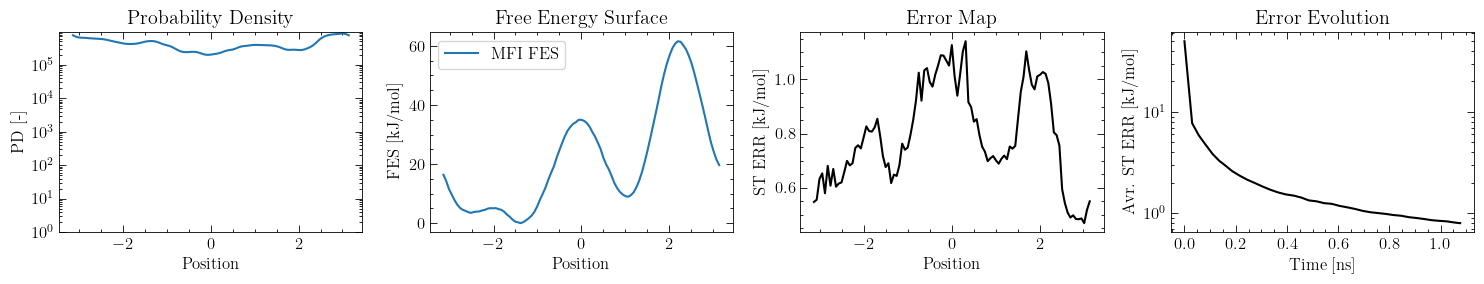


~~~~~~ END ~~~~~~

mfi_PRTR.sim[0].Aofe = 0.7938


In [46]:
# Prepare the MFI object
MFI = MFI_class1D.MFI1D(**default_params)

# Prepare the parallel real-time analysis and re-initialisation object
mfi_PRTR = MFI.MFI_parallel_RTR(parent=MFI, ID="_test", workers=3, n_cores_per_simulation=1, goal=0.01, main_error_type="ST_ERR", n_pos_before_analysis=3000, 
                                guaranteed_sim_time=0.1, max_sim_time=0.3, ### time units [ns] , with metad_pace=500 -> 1ns ~ 400 hills
                                time_budget=1)  # use this for starting a PRTR-campaign for 0 ns.  
								# restart_PRTR=True, time_budget=1.5)  # use this for re-starting a PRTR-campaign from existing data.

# Run the parallel real-time analysis and re-initialisation
mfi_PRTR.run()

# Plot+print the final results
mfi_PRTR.sim[0].plot_results()
print(f"\n~~~~~~ END ~~~~~~\n\n{mfi_PRTR.sim[0].Aofe = :.4f}")


## Calculate and plot average error progression

t=[0.15,100.00] | Final avr: AOFE=0.473, AAD=0.069


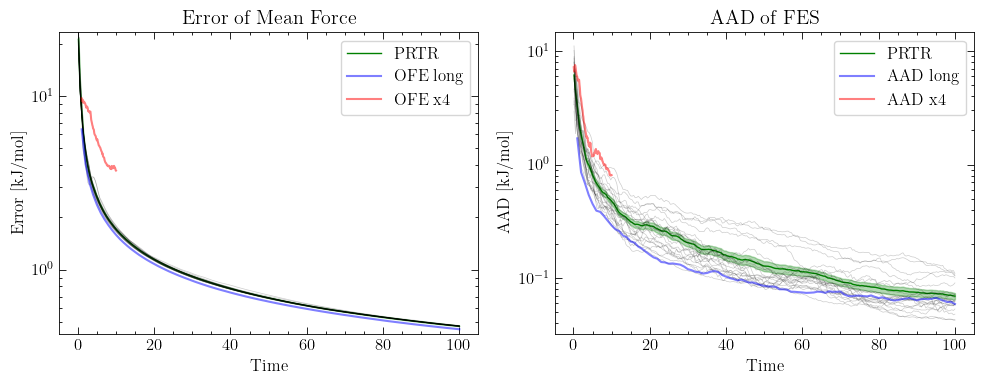

In [75]:
n_surf = 3
total_campaigns = 21
time_budget = 100

# calculate and plot the average error progression
lib1.get_avr_error_prog(path_data, n_surf=n_surf, total_campaigns=total_campaigns, time_budget=time_budget, simulation_type="PRTR", show_plot=False, line_label="PRTR")

# plot the average error progression of the long and 4-patallel simulations
[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_long")
[time_p, ofe_mean_p, ofe_ste_p, aad_mean_p, aad_ste_p] = lib1.load_pkl(path_notebook + "/error_progressions/error_progression_x4_10ns"  )
plt.subplot(1,2,1); plt.plot(time_l, ofe_mean_l, label="OFE long", color="blue", alpha=0.5); plt.plot(time_p, ofe_mean_p, label="OFE x4", color="red", alpha=0.5); plt.legend(); 
plt.subplot(1,2,2); plt.plot(time_l, aad_mean_l, label="AAD long", color="blue", alpha=0.5); plt.plot(time_p, aad_mean_p, label="AAD x4", color="red", alpha=0.5); plt.legend(); 
plt.tight_layout(); plt.show()